## Top 10 Predictor - 2022 Open Championship 

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
%reload_ext nb_black
pd.set_option("display.max_columns", None)
import warnings

warnings.filterwarnings("ignore")

<IPython.core.display.Javascript object>

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn import metrics
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    plot_confusion_matrix,
    make_scorer,
)

<IPython.core.display.Javascript object>

In [4]:
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist, pdist
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

<IPython.core.display.Javascript object>

##### Upload Dataset - Contains raw strokes gained data for seasons 2017 through 2021.  Data from - advancedsportsanalytics.com/pga-raw-data
- Strokes gained data is missing from some events (particularly any overseas events, including The Open Championship)
- Course Rating is proprietary measure used to cluster 'similar' courses to help determine which skill sets best fit each venue.
    - Clusters 0 / 1 / 2 - roughly represent courses that fit ball strikers / well rounded players / or players with exceptional short games.

In [5]:
df = pd.read_csv("C:/Users/Josh/Documents/pga_raw_18_21.csv")
data = df.copy()
data.head()

,Player_initial_last,hole_par,strokes,player,tournament name,course,date,season,Finish,sg_putt,sg_arg,sg_app,sg_ott,sg_t2g,sg_total,course_rating
0,A. Ancer,280,274,Abraham Ancer,Tour Championship,"East Lake Golf Club - Atlanta, GA",9/5/2021,2021,T9,0.16,-0.33,0.59,-0.11,0.15,0.31,1.0
1,B. DeChambeau,280,274,Bryson DeChambeau,Tour Championship,"East Lake Golf Club - Atlanta, GA",9/5/2021,2021,7,-0.18,-0.36,-0.18,1.03,0.49,0.31,1.0
2,B. Horschel,280,270,Billy Horschel,Tour Championship,"East Lake Golf Club - Atlanta, GA",9/5/2021,2021,T9,0.45,-0.07,0.30,0.64,0.86,1.31,1.0
3,B. Koepka,140,138,Brooks Koepka,Tour Championship,"East Lake Golf Club - Atlanta, GA",9/5/2021,2021,WD,0.21,-0.21,-0.85,0.59,-0.47,-0.26,1.0
4,C. Conners,280,278,Corey Conners,Tour Championship,"East Lake Golf Club - Atlanta, GA",9/5/2021,2021,T22,-0.21,-1.49,0.37,0.64,-0.48,-0.69,1.0


<IPython.core.display.Javascript object>

### Data Prep / Manipulation

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20104 entries, 0 to 20103
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Player_initial_last  20104 non-null  object 
 1   hole_par             20104 non-null  int64  
 2   strokes              20104 non-null  int64  
 3   player               20104 non-null  object 
 4   tournament name      20104 non-null  object 
 5   course               20104 non-null  object 
 6   date                 20104 non-null  object 
 7   season               20104 non-null  int64  
 8   Finish               16811 non-null  object 
 9   sg_putt              16811 non-null  float64
 10  sg_arg               16811 non-null  float64
 11  sg_app               16811 non-null  float64
 12  sg_ott               16811 non-null  float64
 13  sg_t2g               16811 non-null  float64
 14  sg_total             16811 non-null  float64
 15  course_rating        17552 non-null 

<IPython.core.display.Javascript object>

In [7]:
# creating new column to see player's score to par
data["total_to_par"] = data["strokes"] - data["hole_par"]

<IPython.core.display.Javascript object>

In [8]:
# changing date column to datetime datatype
data["date"] = pd.to_datetime(data["date"])

<IPython.core.display.Javascript object>

In [9]:
# fixing data in Finish column, removing tie designator and replacing strings with 99
data["Finish"] = data["Finish"].str.replace("T", "", regex=True)
data["Finish"] = data["Finish"].str.replace("WD", "99", regex=True)
data["Finish"] = data["Finish"].str.replace("CUT", "99", regex=True)
data["Finish"] = data["Finish"].str.replace("DQ", "99", regex=True)
data["Finish"] = data["Finish"].str.replace("CU", "99", regex=True)
data["Finish"] = data["Finish"].str.replace("MDF", "99", regex=True)
data["Finish"] = data["Finish"].str.replace("W/D", "99", regex=True)

<IPython.core.display.Javascript object>

In [10]:
# several tournaments don't contained strokes gained data, these are listed as NaN and rows will be dropped
dt = data.dropna()

<IPython.core.display.Javascript object>

In [11]:
# switch finish column to integer datatype
dt["Finish"] = dt["Finish"].astype("int64")

<IPython.core.display.Javascript object>

In [12]:
# create new target column to identify top 10 finishes
dt["top_10"] = dt["Finish"].apply(lambda x: 1 if x < 11 else 0)

<IPython.core.display.Javascript object>

In [13]:
dt.head()

,Player_initial_last,hole_par,strokes,player,tournament name,course,date,season,Finish,sg_putt,sg_arg,sg_app,sg_ott,sg_t2g,sg_total,course_rating,total_to_par,top_10
0,A. Ancer,280,274,Abraham Ancer,Tour Championship,"East Lake Golf Club - Atlanta, GA",2021-09-05,2021,9,0.16,-0.33,0.59,-0.11,0.15,0.31,1.0,-6,1
1,B. DeChambeau,280,274,Bryson DeChambeau,Tour Championship,"East Lake Golf Club - Atlanta, GA",2021-09-05,2021,7,-0.18,-0.36,-0.18,1.03,0.49,0.31,1.0,-6,1
2,B. Horschel,280,270,Billy Horschel,Tour Championship,"East Lake Golf Club - Atlanta, GA",2021-09-05,2021,9,0.45,-0.07,0.30,0.64,0.86,1.31,1.0,-10,1
3,B. Koepka,140,138,Brooks Koepka,Tour Championship,"East Lake Golf Club - Atlanta, GA",2021-09-05,2021,99,0.21,-0.21,-0.85,0.59,-0.47,-0.26,1.0,-2,0
4,C. Conners,280,278,Corey Conners,Tour Championship,"East Lake Golf Club - Atlanta, GA",2021-09-05,2021,22,-0.21,-1.49,0.37,0.64,-0.48,-0.69,1.0,-2,0


<IPython.core.display.Javascript object>

## EDA

In [14]:
dt.describe(include="all").T

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
Player_initial_last,16811,476,T. Hoge,104,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
hole_par,16811.0,NaN,NaN,NaN,NaT,NaT,221.886741,70.663814,70.0,142.0,280.0,284.0,292.0
strokes,16811.0,NaN,NaN,NaN,NaT,NaT,220.216941,66.945257,67.0,146.0,270.0,280.0,313.0
player,16811,478,Tom Hoge,104,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tournament name,16811,50,Travelers Championship,601,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
course,16811,56,"Pebble Beach Resort - Pebble Beach, CA",710,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
date,16811,137,2020-07-12 00:00:00,157,2017-10-08,2021-09-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN
season,16811.0,NaN,NaN,NaN,NaT,NaT,2019.55083,1.134063,2018.0,2019.0,2020.0,2021.0,2021.0
Finish,16811.0,NaN,NaN,NaN,NaT,NaT,62.800785,35.887324,1.0,29.0,64.0,99.0,99.0
sg_putt,16811.0,NaN,NaN,NaN,NaT,NaT,-0.127666,1.122626,-5.82,-0.79,-0.04,0.62,4.3


<IPython.core.display.Javascript object>

#### Strokes Gained 

In [15]:
sg_cols = ["sg_putt", "sg_arg", "sg_app", "sg_ott", "sg_t2g", "sg_total"]

<IPython.core.display.Javascript object>

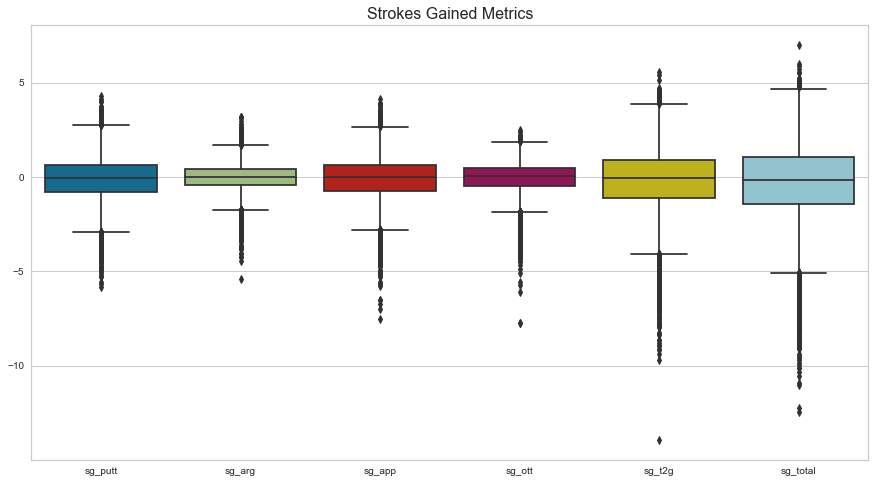

<IPython.core.display.Javascript object>

In [16]:
plt.figure(figsize=(15, 8))
sns.boxplot(data=dt[sg_cols])
sns.set_theme(style="darkgrid")
plt.title("Strokes Gained Metrics", fontsize=16)
plt.show()

- Each of the strokes gained metrics have a median around 0.
- Strokes gained total and strokes gained tee to green have the widest variance, but this is intuitive as these metrics represent the performance of multiple shots.
- There are more strokes to be gained or lost in approach and putting than around the green and off the tee.

#### Top 10

In [17]:
def labeled_bar(df, feature, figsize=(20, 20)):
    ax = sns.countplot(
        data=df,
        x=feature,
        palette="Dark2",
        order=df[feature].value_counts(ascending=False).index,
    )
    for p in ax.patches:
        ax.annotate(f"\n{p.get_height()}", (p.get_x() + 0.35, p.get_height()))
    plt.xticks(rotation=60)

<IPython.core.display.Javascript object>

In [18]:
def rel_plot(dt, feature1, feature2, hue="top_10"):
    ax = sns.relplot(data=dt, x=feature1, y=feature2, hue=hue, palette="Dark2")

<IPython.core.display.Javascript object>

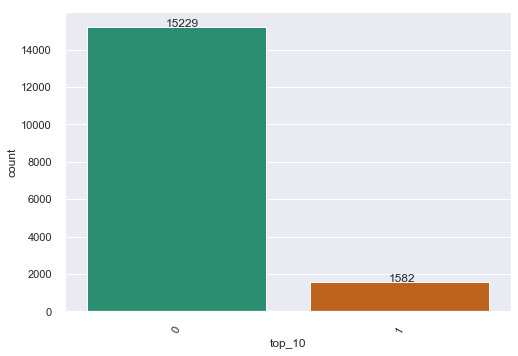

<IPython.core.display.Javascript object>

In [19]:
labeled_bar(dt, "top_10")

In [20]:
top10 = dt[dt["top_10"] == 1]
print(
    round(len(top10) / len(dt) * 100, 2),
    "% of players in the dataset finished in the top 10",
)

9.41 % of players in the dataset finished in the top 10


<IPython.core.display.Javascript object>

#### Relationship between Strokes Gained Metrics, with Top 10

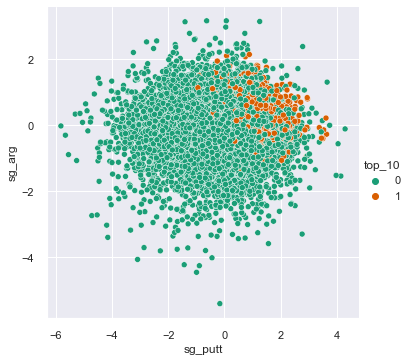

<IPython.core.display.Javascript object>

In [21]:
rel_plot(dt, "sg_putt", "sg_arg")

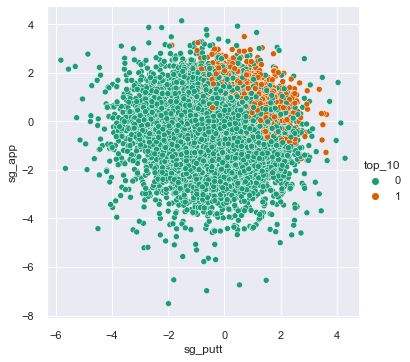

<IPython.core.display.Javascript object>

In [22]:
rel_plot(dt, "sg_putt", "sg_app")

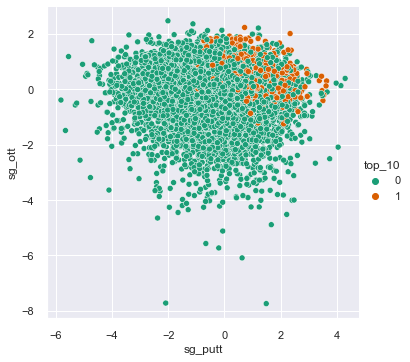

<IPython.core.display.Javascript object>

In [23]:
rel_plot(dt, "sg_putt", "sg_ott")

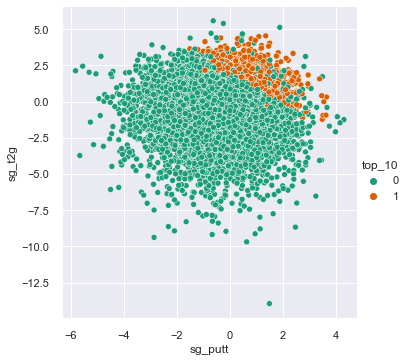

<IPython.core.display.Javascript object>

In [24]:
rel_plot(dt, "sg_putt", "sg_t2g")

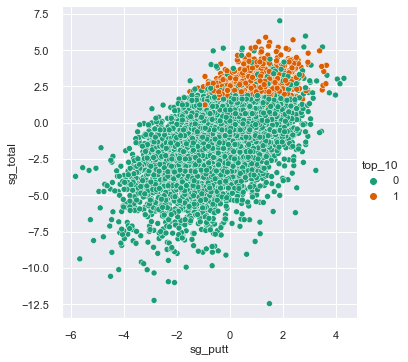

<IPython.core.display.Javascript object>

In [25]:
rel_plot(dt, "sg_putt", "sg_total")

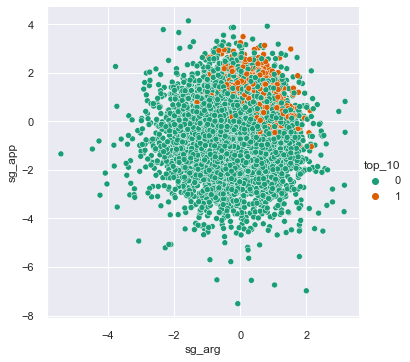

<IPython.core.display.Javascript object>

In [26]:
rel_plot(dt, "sg_arg", "sg_app")

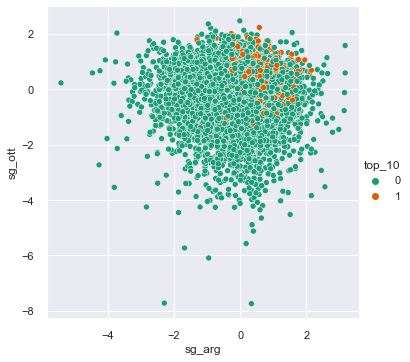

<IPython.core.display.Javascript object>

In [27]:
rel_plot(dt, "sg_arg", "sg_ott")

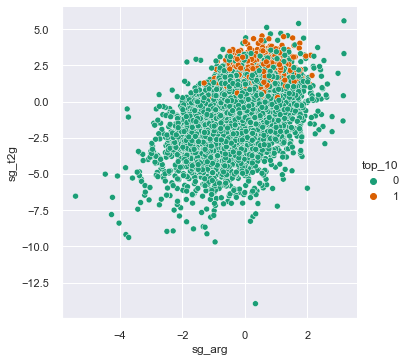

<IPython.core.display.Javascript object>

In [28]:
rel_plot(dt, "sg_arg", "sg_t2g")

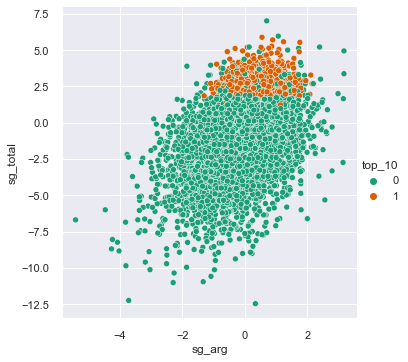

<IPython.core.display.Javascript object>

In [29]:
rel_plot(dt, "sg_arg", "sg_total")

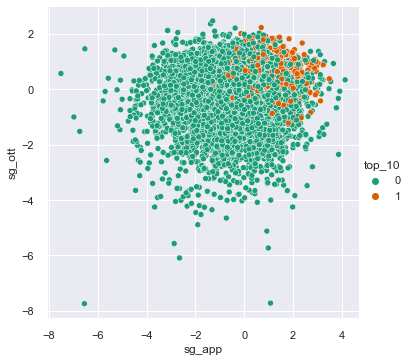

<IPython.core.display.Javascript object>

In [30]:
rel_plot(dt, "sg_app", "sg_ott")

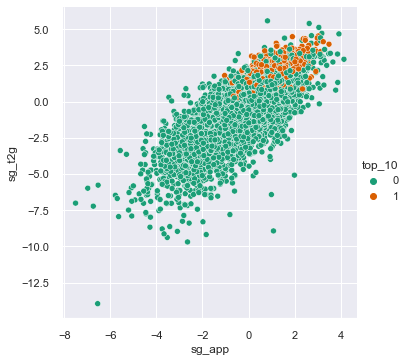

<IPython.core.display.Javascript object>

In [31]:
rel_plot(dt, "sg_app", "sg_t2g")

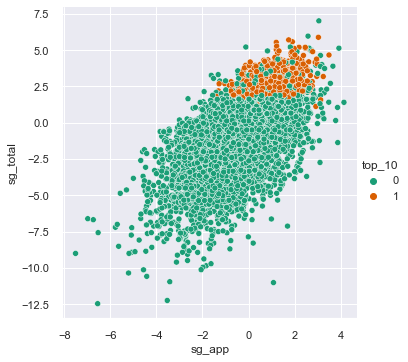

<IPython.core.display.Javascript object>

In [32]:
rel_plot(dt, "sg_app", "sg_total")

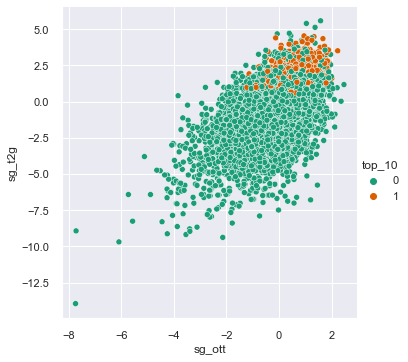

<IPython.core.display.Javascript object>

In [33]:
rel_plot(dt, "sg_ott", "sg_t2g")

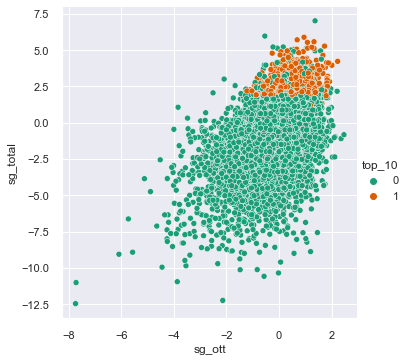

<IPython.core.display.Javascript object>

In [34]:
rel_plot(dt, "sg_ott", "sg_total")

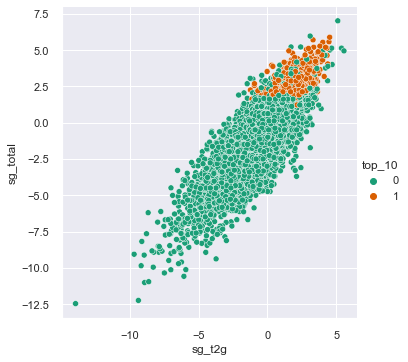

<IPython.core.display.Javascript object>

In [35]:
rel_plot(dt, "sg_t2g", "sg_total")

- SG Putting seems to be the least correlated among the strokes gained statistics
- SG Around the Green seems to be the least likely to predict a top 10 finish.
- SG Tee to Green and SG Total are aggregates of other measures, and thus are the most heavily correlated.  For model building, it may be necessary to remove some heavily correlated measures for best results.
- SG Total seems to have a very clear limit around 2 Strokes gained, at which a player is highly likely to finish top 10.  This will be investigated further.

#### Strokes Gained Total vs. Top 10

In [36]:
sg2 = dt[dt["sg_total"] > 2.3]

<IPython.core.display.Javascript object>

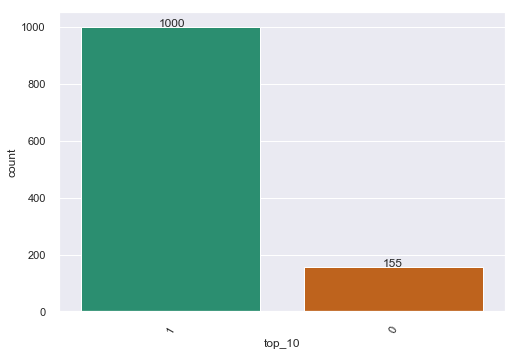

<IPython.core.display.Javascript object>

In [37]:
labeled_bar(sg2, "top_10")

In [38]:
sg2top = sg2[sg2["top_10"] == 1]
print(
    round(len(sg2top) / len(sg2) * 100, 2),
    "% of players who have more than 2.3 strokes gained total for the week finish in the top 10",
)

86.58 % of players who have more than 2.3 strokes gained total for the week finish in the top 10


<IPython.core.display.Javascript object>

- Using the distribution of the scatter plots, it's easy to see the strokes gained totals that strongly predict top 10 results.
- Future player analyses could evaluate how often players exceed 2.3 strokes gained total for given weeks.  Players who regularly gain more than 2.3 strokes gained are good picks to finish top 10 week in and week out.

#### Strokes Gained Total vs. Score to Par

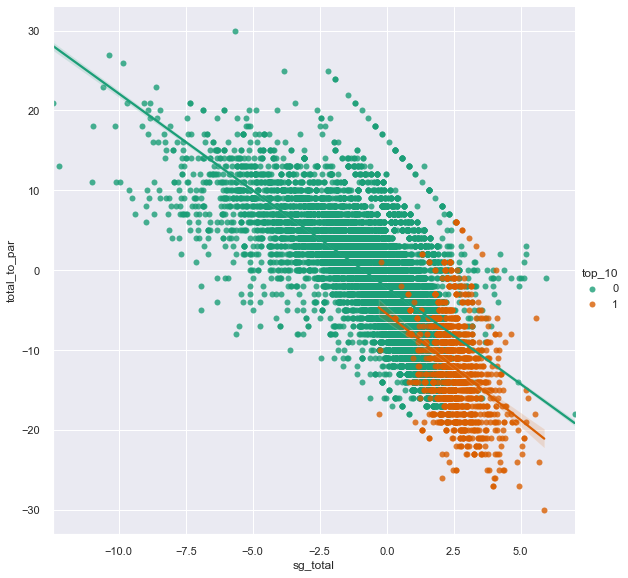

<IPython.core.display.Javascript object>

In [39]:
ax = sns.lmplot(
    data=dt, x="sg_total", y="total_to_par", hue="top_10", palette="Dark2", height=8
)
plt.show()

- Par is an arbritrary number and varies for each course, and ultimately the field is all playing the same course.  However players who score -17 or lower are essentially guaranteed a top 10 finish.
- Players who total the magic number of 2.3 strokes gained in a week are likely to finish somewhere around -8 to -11.

#### Correlation Heatmap

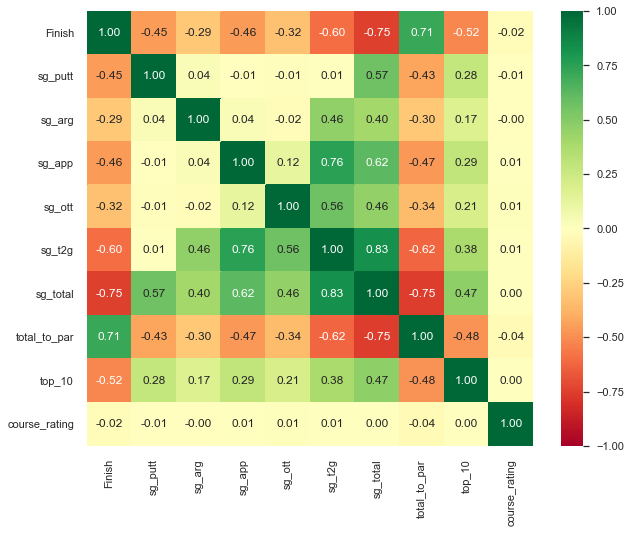

<IPython.core.display.Javascript object>

In [40]:
num_corr = [
    "Finish",
    "sg_putt",
    "sg_arg",
    "sg_app",
    "sg_ott",
    "sg_t2g",
    "sg_total",
    "total_to_par",
    "top_10",
    "course_rating",
]
corr = dt[num_corr].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="RdYlGn")
plt.show()

- As previously noted, Strokes gained Tee to Green and Strokes Gained Total are aggregrate totals and thus correlate too heavily to be included in model building with the raw metrics.
- Using correlation scores, strokes gained putting and strokes gained approach correlate most heavily to top 10 finish
    - Strokes Gained Around the Green seems to be the least predictive

## Prepare Data for Model Building

In [41]:
mdata = dt.copy()

<IPython.core.display.Javascript object>

In [42]:
mdata.drop(
    [
        "Player_initial_last",
        "hole_par",
        "strokes",
        "player",
        "tournament name",
        "course",
        "date",
        "season",
    ],
    axis=1,
    inplace=True,
)

<IPython.core.display.Javascript object>

In [43]:
mdata.head()

,Finish,sg_putt,sg_arg,sg_app,sg_ott,sg_t2g,sg_total,course_rating,total_to_par,top_10
0,9,0.16,-0.33,0.59,-0.11,0.15,0.31,1.0,-6,1
1,7,-0.18,-0.36,-0.18,1.03,0.49,0.31,1.0,-6,1
2,9,0.45,-0.07,0.30,0.64,0.86,1.31,1.0,-10,1
3,99,0.21,-0.21,-0.85,0.59,-0.47,-0.26,1.0,-2,0
4,22,-0.21,-1.49,0.37,0.64,-0.48,-0.69,1.0,-2,0


<IPython.core.display.Javascript object>

In [44]:
X = mdata.drop(["top_10"], axis=1)
y = mdata["top_10"]

<IPython.core.display.Javascript object>

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

<IPython.core.display.Javascript object>

## Functions for Scoring / Confusion Matrix

In [46]:
def model_perf(model, predictors, target):
    pred = model.predict(predictors)
    acc = accuracy_score(target, pred)
    recall = recall_score(target, pred)
    precision = precision_score(target, pred)
    f1 = f1_score(target, pred)

    df_perf = pd.DataFrame(
        {"Accuracy": acc, "Recall": recall, "Precision": precision, "F1": f1},
        index=[0],
    )
    return df_perf

<IPython.core.display.Javascript object>

In [47]:
def confusion_matrix(model, y_actual, labels=[1, 0]):
    y_predict = model.predict(X_test)
    cm = metrics.confusion_matrix(y_actual, y_predict, labels=[0, 1])
    df_cm = pd.DataFrame(
        cm,
        index=[i for i in ["Actual - No", "Actual - Yes"]],
        columns=[i for i in ["Predicted - No", "Predicted - Yes"]],
    )
    group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cm.flatten() / np.sum(cm)]
    labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2, 2)
    plt.figure(figsize=(10, 7))
    sns.heatmap(df_cm, annot=labels, fmt="")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

<IPython.core.display.Javascript object>

## Fit Models

In [48]:
selected_features = ["sg_putt", "sg_app", "sg_total", "course_rating"]

<IPython.core.display.Javascript object>

In [49]:
X_train = X_train[selected_features]
X_test = X_test[selected_features]

<IPython.core.display.Javascript object>

In [50]:
X_train.describe()

,sg_putt,sg_app,sg_total,course_rating
count,11767.000000,11767.000000,11767.000000,11767.000000
mean,-0.130196,-0.121265,-0.358349,0.872185
std,1.125294,1.107622,1.983884,0.963015
min,-5.820000,-7.510000,-12.460000,0.000000
25%,-0.800000,-0.750000,-1.430000,0.000000
50%,-0.040000,-0.020000,-0.210000,0.000000
75%,0.630000,0.620000,1.000000,2.000000
max,4.300000,4.140000,7.010000,2.000000


<IPython.core.display.Javascript object>

In [51]:
xg = XGBClassifier(random_state=1)
xg.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=1,
              reg_alpha=0, reg_lambda=1, ...)

<IPython.core.display.Javascript object>

In [52]:
model_perf(xg, X_train, y_train)

,Accuracy,Recall,Precision,F1
0,0.993541,0.970534,0.959927,0.965201


<IPython.core.display.Javascript object>

In [53]:
model_perf(xg, X_test, y_test)

,Accuracy,Recall,Precision,F1
0,0.96134,0.830645,0.787763,0.808636


<IPython.core.display.Javascript object>

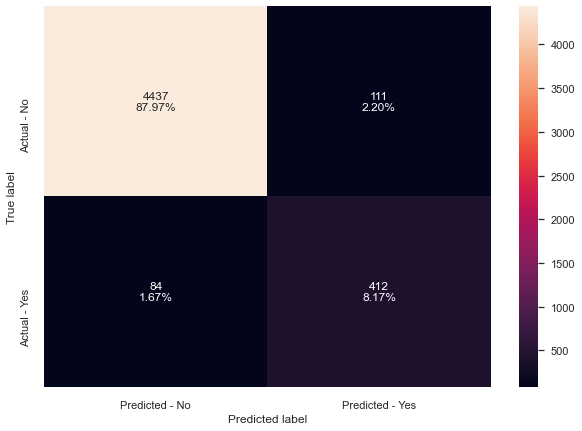

<IPython.core.display.Javascript object>

In [54]:
confusion_matrix(xg, y_test)

- In this iteration of the model, it isn't tuned and not adjusted for imbalanced data but really performs quite well.
- It's very realistic to develop more sofisticated models to achieve 98% accuracy with 85% Recall and Precision.

## Apply 2022 Scoring Data for Predictions - Open Championship

In [55]:
# load dataset of 2022 Strokes gained data - taken for season to date
newdata = pd.read_excel("C:/Users/Josh/Documents/open_champ22_sg.xlsx")

<IPython.core.display.Javascript object>

In [56]:
newdata.head()

,Unnamed: 0,Unnamed: 1,sg_putt,sg_arg,sg_app,sg_ott,sg_t2g,sg_total,course_rating,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12
0,Ancer,Abraham,0.17,-0.45,0.03,0.40,-0.02,0.15,1,NaN,NaN,NaN,NaN
1,Armitage,Marcus,-0.53,-0.26,0.72,0.07,0.53,0.00,1,-0.33,-0.06,0.92,0.27
2,Arnaus,Adri,0.26,-0.30,0.18,0.17,0.05,0.31,1,0.46,-0.10,0.38,0.37
3,Bezuidenhout,Christiaan,0.40,0.01,0.23,0.18,0.42,0.82,1,NaN,NaN,NaN,NaN
4,Bjork,Alexander,0.47,0.20,0.09,-0.68,-0.39,0.08,1,0.67,0.40,0.29,-0.48


<IPython.core.display.Javascript object>

In [57]:
# DP World tour players were assigned a -.20 adjustment to sg_putt, sg_arg, sg_app, and sg_ott
# Dropping Unnamed columns which contained raw DP world Tour data

newdata.drop(
    ["Unnamed: 9", "Unnamed: 10", "Unnamed: 11", "Unnamed: 12"], axis=1, inplace=True,
)

<IPython.core.display.Javascript object>

In [58]:
# renaming columns containing players' names
newdata.rename(
    columns={"Unnamed: 0": "Last Name", "Unnamed: 1": "First Name"}, inplace=True
)

<IPython.core.display.Javascript object>

In [59]:
# applying 85% multiplier to unseen data to adjust from season long data to predict for one tournament
newdata["sg_putt"] *= 0.85
newdata["sg_app"] *= 0.85
newdata["sg_total"] *= 0.85

<IPython.core.display.Javascript object>

In [60]:
newdata["top_10"] = xg.predict(newdata[selected_features])

<IPython.core.display.Javascript object>

In [61]:
top_picks = newdata[newdata["top_10"] == 1]
top_picks.head(20)

,Last Name,First Name,sg_putt,sg_arg,sg_app,sg_ott,sg_t2g,sg_total,course_rating,top_10
6,Bradley,Keegan,0.0850,0.15,0.5355,0.42,1.20,1.1050,1,1
8,Burns,Sam,0.4590,0.19,0.5695,0.15,1.01,1.3175,1,1
28,Gooch,Talor,0.0085,0.50,0.5525,-0.13,1.02,0.8755,1,1
41,Horsfield,Sam,0.4250,0.04,0.9860,-0.06,1.14,1.3940,1,1
63,Lowry,Shane,0.2975,0.18,0.6375,0.34,1.27,1.3770,1,1
66,Matsuyama,Hideki,-0.0425,0.19,0.7480,0.20,1.27,1.0370,1,1
67,McIlroy,Rory,0.5100,0.21,0.5610,0.83,1.70,1.9550,1,1
81,Pereira,Mito,0.0510,0.06,0.5950,0.45,1.21,1.0795,1,1
83,Pieters,Thomas,0.1955,0.17,0.4335,0.66,1.34,1.3345,1,1
87,Rahm,Jon,0.1615,-0.07,0.4505,1.01,1.47,1.4110,1,1


<IPython.core.display.Javascript object>